### Creating a class for the project

In [1]:
import numpy 
numpy.random.seed(seed=10)

# Creating a class for GAN
Reference : Intro to GAN video series by Dr Sunil Kumar Vuppala

In [10]:
class gan:
  def __init__(self):
    """ The function will check if there is a pretrained model already in the 
    folder. If found, it will load the data. Otherwise, it will return error message"""

    print('Class initialized')
    import os
    from keras.models import  load_model
    flag=0
    for file in os.listdir():
      if file=='mnist_generator_dcgan.h5':
        self.model=load_model(file)
        print('Pre trained model loaded')
        flag=1
    if flag==0:
      print('Pre trained model not found')
            
  

  def create_generator(self,image_size=28,input_size=100):
    ''' The function creates a generative model use=ing Keras and returns the model
    The image is first converted into a smaller dimension with more channels. 
    Once this is done, we use futher Conv2D transpose operation to increase the size of the imahe
    and to decrese the number of channels.
    After the process, the model ends up creating an image of size 28x28 in the last layer. 
    '''

    import keras 
    import tensorflow as tf
    #Build an input layer
    gen_input = tf.keras.layers.Input(shape=(input_size,))
    
    #Increase dimensions and resize to 3D to feed it to Conv2DTranspose layer
    x = tf.keras.layers.Dense(7 * 7 * 128)(gen_input)
    x = tf.keras.layers.Reshape((7, 7, 128))(x)
    
    #Use ConvTranspose
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=[5,5], strides=1, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(1, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Output layer for Generator
    x = tf.keras.layers.Activation('sigmoid')(x)
    
    #Build model using Model API
    generator = tf.keras.models.Model(gen_input, x, name='generator')
    
    return generator

    
  def create_discriminator(self,shape=[28,28,1,]):
      """ Function to build the discriminator network from scratch using the tensorflow 
      and keras libraries"""
      import tensorflow as tf
      #Build the network
      dis_input = tf.keras.layers.Input(shape)
      x = tf.keras.layers.LeakyReLU(alpha=0.2)(dis_input)
      x = tf.keras.layers.Conv2D(32, kernel_size=[5,5], strides=2, padding='same')(x)
      
      x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
      x = tf.keras.layers.Conv2D(64, kernel_size=[5,5], strides=2, padding='same')(x)
      
      x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
      x = tf.keras.layers.Conv2D(128, kernel_size=[5,5], strides=2, padding='same')(x)
      
      x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
      x = tf.keras.layers.Conv2D(256, kernel_size=[5,5], strides=1, padding='same')(x)
      
      #Flatten the output and build an output layer
      x = tf.keras.layers.Flatten()(x)
      x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
      
      #Build Model
      discriminator = tf.keras.models.Model(dis_input, x, name='discriminator')
      
      return discriminator



  def build_model(self):
    """ The function creates a GAN model by using the discrimnator and generator models which were
    defined in the earlier funtions inside the class. It also returns the generator, disciminator and 
    adversarial network after creating the model"""
    import tensorflow as tf

    noise_size = 100
    lr = 2e-4
    decay = 6e-8
    
    #Build Base Discriminator model
    base_discriminator = self.create_discriminator()
    
    #Define optimizer and compile model
    discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    optimizer = tf.keras.optimizers.RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    
    #Build Generator model
    generator = self.create_generator(image_size=28, input_size=noise_size)
    
    #Build Frozen Discriminator
    frozen_discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    #Freeze the weights of discriminator during adversarial training
    frozen_discriminator.trainable = False

    #Build Adversarial model
    optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    #Adversarial = generator + discriminator
    adversarial = tf.keras.models.Model(generator.input, 
                        frozen_discriminator(generator.output))
    
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])    
    
    return generator, discriminator, adversarial





  def train_gan(self,generator,discriminator,adversarial_network,distribution_size=100,batch_size=64):
    import tensorflow as tf
    import numpy as np
    #Training parameters
    batch_size = 64
    train_steps = 3000
    image_size = 28
    
    # load MNIST dataset
    (train_x, train_y), (_, _) = tf.keras.datasets.mnist.load_data()
    train_x=train_x[np.where(train_y==5)]
    #Make it 3D dataset
    train_x = np.reshape(train_x, [-1, image_size, image_size, 1])
    #Standardize data : 0 to 1
    train_x = train_x.astype('float32') / 255
    
    #Input for testing generator at different intervals, we will generate 16 images
    test_noise_input = np.random.uniform(-1.0,1.0, size=[16, distribution_size])
    
    #Start training
    for i in range(train_steps):
        
        #Train DISCRIMATOR
        
        #1. Get fake images from Generator
        noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, distribution_size])
        fake_images = generator.predict(noise_input)
        
        #2. Get real images from training set
        img_indexes = np.random.randint(0, train_x.shape[0], size=batch_size)
        real_images = train_x[img_indexes]
        
        #3. Prepare input for training Discriminator
        X = np.concatenate((real_images, fake_images))
        
        #4. Labels for training
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        y = np.concatenate((y_real, y_fake))
        
        #5. Train Discriminator
        d_loss, d_acc = discriminator.train_on_batch(X, y)
        
        
        #Train ADVERSARIAL Network
        
        #1. Prepare input - create a new batch of noise
        X = noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, distribution_size])
        
        #2. Prepare labels - training Adversarial network to lie :) - All 1s
        y = np.ones((batch_size, 1))
        
        #3. Train - Pls note Discrimator is not getting trained here
        a_loss, a_acc = adversarial_network.train_on_batch(X, y)
        
        if i % 100 == 0:
            #Print loss and Accuracy for both networks
            print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (i, d_loss, d_acc, a_loss, a_acc) )
        
        #Save generated images to see how well Generator is doing
        if (i+1) % 500 == 0:
            
            #Generate 16 images
            fake_images = generator.predict(test_noise_input)
            
            #Display images
            self.plot_images(fake_images, i+1)
            
    #Save Generator model
    self.model=generator
    generator.save('mnist_generator_dcgan.h5')   




  def plot_images(self,fake_images, step):
    '''  The function helps in plotting the graphs, so that it is easy to 
    see how the model trains '''
    
    import matplotlib.pyplot as plt
    import math
    import numpy as np
    plt.figure(figsize=(2.5,2.5))
    num_images = fake_images.shape[0]
    
    image_size = fake_images.shape[1]
    rows = int(math.sqrt(fake_images.shape[0]))
    
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(fake_images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

  def generate_fives(self,number):
    ''' This function will generate 'number' number of 5's and will return the array'''
    noise_input = np.random.uniform(-1.0,1.0, size=[number, 100])
    fake_images = self.model.predict(noise_input)
    return fake_images


## Calling the GAN functions

In [15]:
gan_object=gan()
Generator,Discriminator,Adversarial=gan_object.build_model()


Class initialized
Pre trained model loaded


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


# Batch size :64

0 [Discriminator loss: 0.694395, acc: 0.234375, Adversarial loss: 0.848815, acc: 0.000000]
100 [Discriminator loss: 0.000041, acc: 1.000000, Adversarial loss: 0.000157, acc: 1.000000]
200 [Discriminator loss: 0.000026, acc: 1.000000, Adversarial loss: 0.000187, acc: 1.000000]
300 [Discriminator loss: 0.000038, acc: 1.000000, Adversarial loss: 0.000009, acc: 1.000000]
400 [Discriminator loss: 0.008150, acc: 1.000000, Adversarial loss: 0.038980, acc: 1.000000]


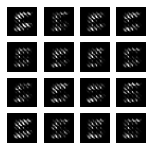

500 [Discriminator loss: 0.305606, acc: 0.843750, Adversarial loss: 2.624250, acc: 0.000000]
600 [Discriminator loss: 0.207906, acc: 0.929688, Adversarial loss: 1.199475, acc: 0.250000]
700 [Discriminator loss: 0.009780, acc: 1.000000, Adversarial loss: 0.000175, acc: 1.000000]
800 [Discriminator loss: 0.330352, acc: 0.867188, Adversarial loss: 0.451019, acc: 0.781250]


In [ ]:
import time
start=time.time()

gan_object.train_gan(Generator,Discriminator,Adversarial)
print(time.time()-start)

# Batch Size = 128


In [ ]:
gan_object=gan()
Generator,Discriminator,Adversarial=gan_object.build_model()

import time
start=time.time()

gan_object.train_gan(Generator,Discriminator,Adversarial,batch_size=128)
print(time.time()-start)

# Batch Size = 256

In [ ]:
gan_object=gan()
Generator,Discriminator,Adversarial=gan_object.build_model()

import time
start=time.time()

gan_object.train_gan(Generator,Discriminator,Adversarial,batch_size=256)
print(time.time()-start)

# Batch Size = 512


In [ ]:
gan_object=gan()
Generator,Discriminator,Adversarial=gan_object.build_model()

import time
start=time.time()

gan_object.train_gan(Generator,Discriminator,Adversarial,batch_size=512)
print(time.time()-start)